<a href="https://colab.research.google.com/github/tmelo-uea/cursos/blob/main/CursoAnaliseImagensMedicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importar pacotes

In [1]:
import os
import numpy as np
import pandas as pd
import pathlib
import imageio
import random

#Explorar datasets

Os conjuntos de dados (datasets) são divididos em três partes: A) treino; B) validação; C) teste.

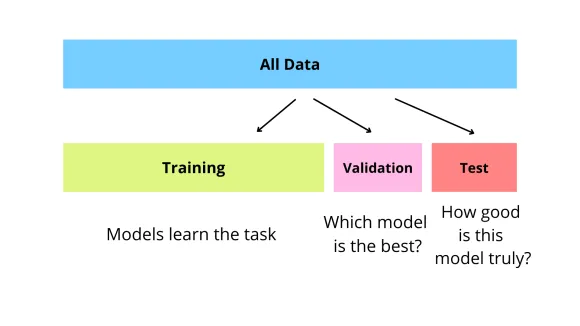

O nosso conjunto de dados é uma representação de imagens de raio-x do pulmão [[link]](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia).

O nosso conjunto total possui 5.863 imagens.

Cada parte tem um conjunto de imagens normais e com pneumonia.

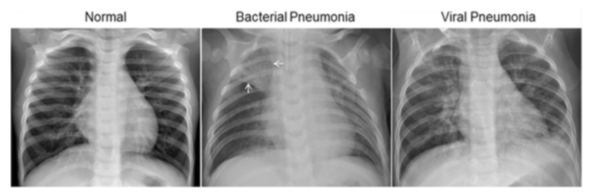

### Código de Leitura dos Dados (Google Drive)

In [60]:
base_dir = '/content/drive/MyDrive/cursos2024/code/chest_xray/'
base_dir = '/content/drive/MyDrive/cursos2024/code/chest_xray_menor/'

train_pneumonia_dir = base_dir+'train/PNEUMONIA/'
train_normal_dir=base_dir+'train/NORMAL/'

test_pneumonia_dir = base_dir+'test/PNEUMONIA/'
test_normal_dir = base_dir+'test/NORMAL/'

val_normal_dir= base_dir+'val/NORMAL/'
val_pnrumonia_dir= base_dir+'val/PNEUMONIA/'

train_pn = [train_pneumonia_dir+"{}".format(i) for i in os.listdir(train_pneumonia_dir) ]
train_normal = [train_normal_dir+"{}".format(i) for i in os.listdir(train_normal_dir) ]

test_normal = [test_normal_dir+"{}".format(i) for i in os.listdir(test_normal_dir)]
test_pn = [test_pneumonia_dir+"{}".format(i) for i in os.listdir(test_pneumonia_dir)]

val_pn= [val_pnrumonia_dir+"{}".format(i) for i in os.listdir(val_pnrumonia_dir) ]
val_normal= [val_normal_dir+"{}".format(i) for i in os.listdir(val_normal_dir) ]

print ("Total imagens:",len(train_pn+train_normal+test_normal+test_pn+val_pn+val_normal))
print ("Total pneumonia imagens:",len(train_pn+test_pn+val_pn))
print ("Total normal imagens:",len(train_normal+test_normal+val_normal))

Total imagens: 200
Total pneumonia imagens: 100
Total normal imagens: 100


#Organização dos datasets

In [61]:
train_imgs = train_pn + train_normal
test_imgs = test_pn + test_normal
val_imgs = val_pn + val_normal

#Gerando aleatoriedade nos dados
random.shuffle(train_imgs)
random.shuffle(test_imgs)
random.shuffle(val_imgs)

print ('Treino:', len(train_imgs))
print ('Teste:', len(test_imgs))
print ('Validação:', len(val_imgs))

Treino: 160
Teste: 30
Validação: 10


#Função de pré-processamento das imagens

In [62]:
import cv2 #Importa a biblioteca OpenCV, que é amplamente utilizada para processamento de imagens.
img_size = 224 #Define o tamanho para o qual as imagens serão redimensionadas, neste caso 224x224 pixels. Este é um tamanho comum para modelos de redes neurais convolucionais (CNNs).

def preprocess_image(image_list):
    X = [] # imagens
    y = [] # rótulos (0 para normal e 1 para pneumonia)
    count=0

    for image in image_list:
        try:
            img = cv2.imread(image,cv2.IMREAD_GRAYSCALE) # Lê a imagem do disco em escala de cinza.
            img = cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_CUBIC) #Redimensiona a imagem para 224x224 pixels usando interpolação cúbica, que é uma forma de interpolação que considera os valores dos pixels vizinhos para calcular um novo valor de pixel, resultando em uma imagem redimensionada de alta qualidade.

            #Conversão de 2D para 3D
            img = np.dstack([img, img, img]) #Converte a imagem de escala de cinza (uma camada) em uma imagem de 3 canais empilhando a mesma imagem três vezes. Isso simula uma imagem RGB.

            #Conversão para RGB:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Converte a imagem de BGR para RGB. O OpenCV carrega imagens no formato BGR por padrão, então é preciso converter para RGB, que é o formato usado por muitas outras bibliotecas de processamento de imagens e visualização.

            # Normalização
            img = img.astype(np.float32)/255. # Normaliza a imagem convertendo os valores dos pixels para um intervalo de 0 a 1. Isso ajuda na convergência durante o treinamento de modelos de rede neural, mantendo os valores dos pesos dentro de uma escala gerenciável.
            count=count+1
            X.append(img)
        except:
            print ('Falha na conversão.')
            continue

        #Obtenção dos Rótulos
        #As imagens são classificadas com base no nome do arquivo: A) Se o nome contém 'NORMAL' ou 'IM', o rótulo é 0 (normal). B) Se o nome contém 'virus' ou 'bacteria', o rótulo é 1 (pneumonia).
        if 'NORMAL' in image:
            y.append(0)
        elif 'IM' in image:
            y.append(0)
        elif 'virus' or 'bacteria' in image:
            y.append(1)

    return X, y

#Dados de Treino

In [63]:
X, y = preprocess_image(train_imgs)

In [64]:
# Checar todas as imagens de acordo com os rótulos
arr=y
uniqueValues, occurCount = np.unique(arr, return_counts=True)

print("Valores únicos: " , uniqueValues)
print("Quantidade de ocorrências: ", occurCount)

Valores únicos:  [0 1]
Quantidade de ocorrências:  [80 80]


### Visualização de algumas imagens de dados de treino

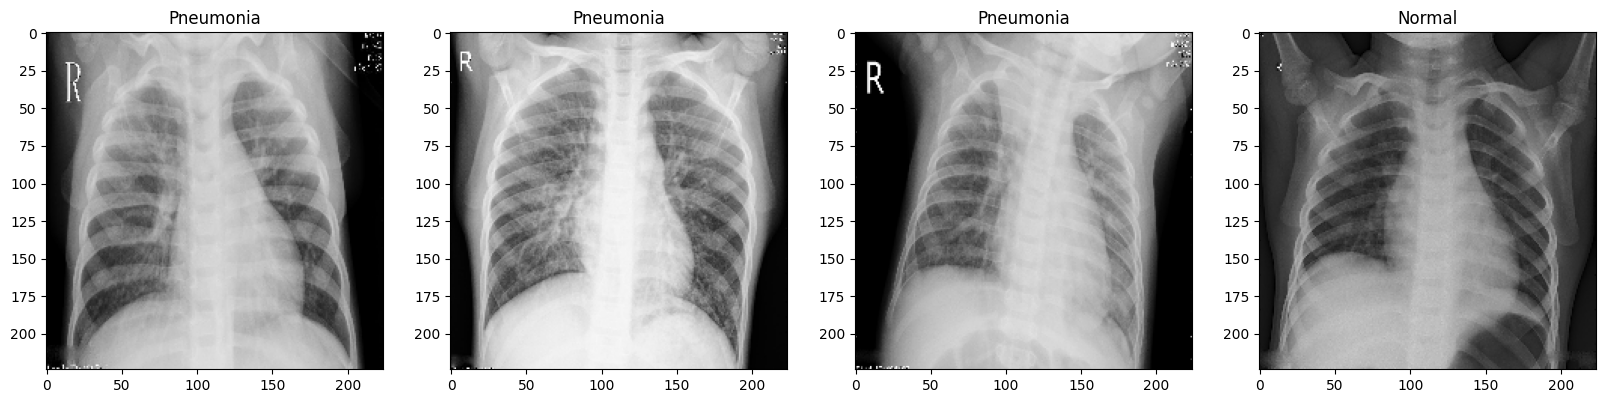

In [65]:
#Mostrar algumas imagens de dados de treino
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    if (y[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')

    plt.imshow(X[i])
    k=k+1;

#Dados de teste

In [66]:
# Pegar os rótulos para o conjunto de teste
P, t = preprocess_image(test_imgs)

In [67]:
arr=t
uniqueValues, occurCount = np.unique(arr, return_counts=True)

print("Valores únicos: " , uniqueValues)
print("Quantidade de ocorrências: ", occurCount)

Valores únicos:  [0 1]
Quantidade de ocorrências:  [15 15]


### Visualizar algumas imagens de dados de teste

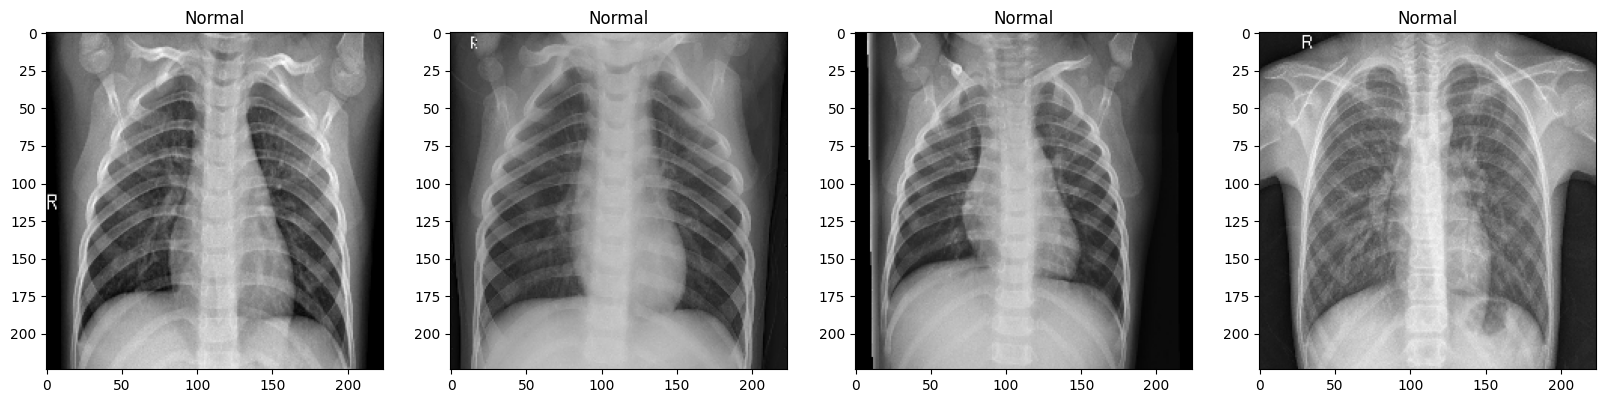

In [68]:
#Mostrar os dados de teste

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    if (t[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')

    plt.imshow(P[i])
    k=k+1;

#Dados de validação

In [69]:
#Pegar os rótulos
K, m = preprocess_image(val_imgs)

In [70]:
arr=m

uniqueValues, occurCount = np.unique(arr, return_counts=True)

print("Valores únicos: " , uniqueValues)
print("Quantidade de ocorrências: ", occurCount)

Valores únicos:  [0 1]
Quantidade de ocorrências:  [5 5]


### Visualizar algumas imagens de validação

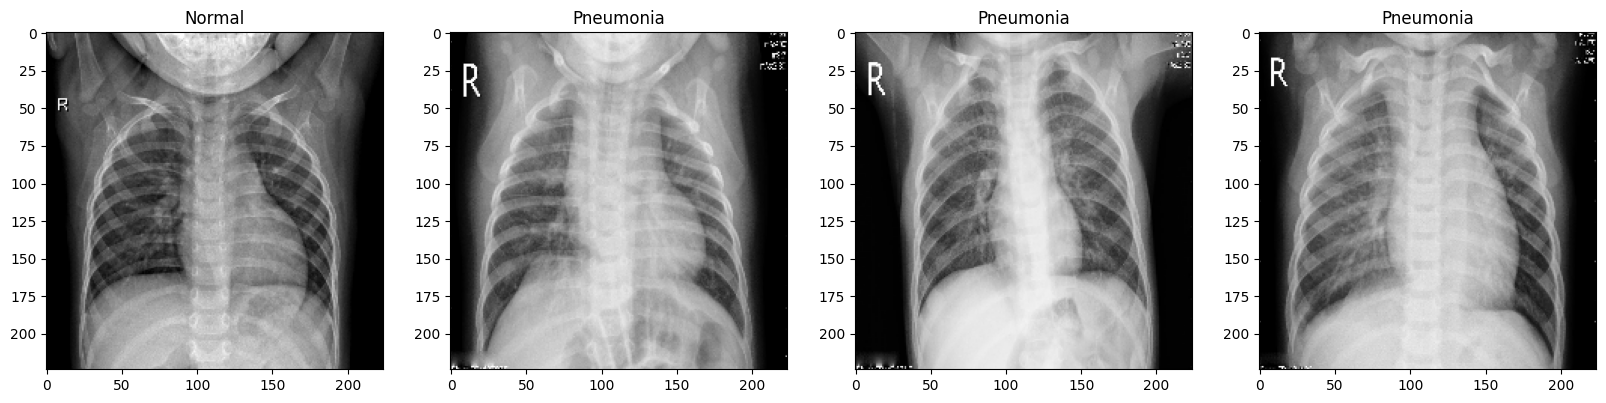

In [71]:
#Mostrar o conjunto de validação

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 5))
k=1
for i in range(4):
    a = fig.add_subplot(1, 4, k)
    if (m[i]==0):
        a.set_title('Normal')
    else:
        a.set_title('Pneumonia')

    plt.imshow(K[i])
    k=k+1;

#Gráfico de distribuição de dados

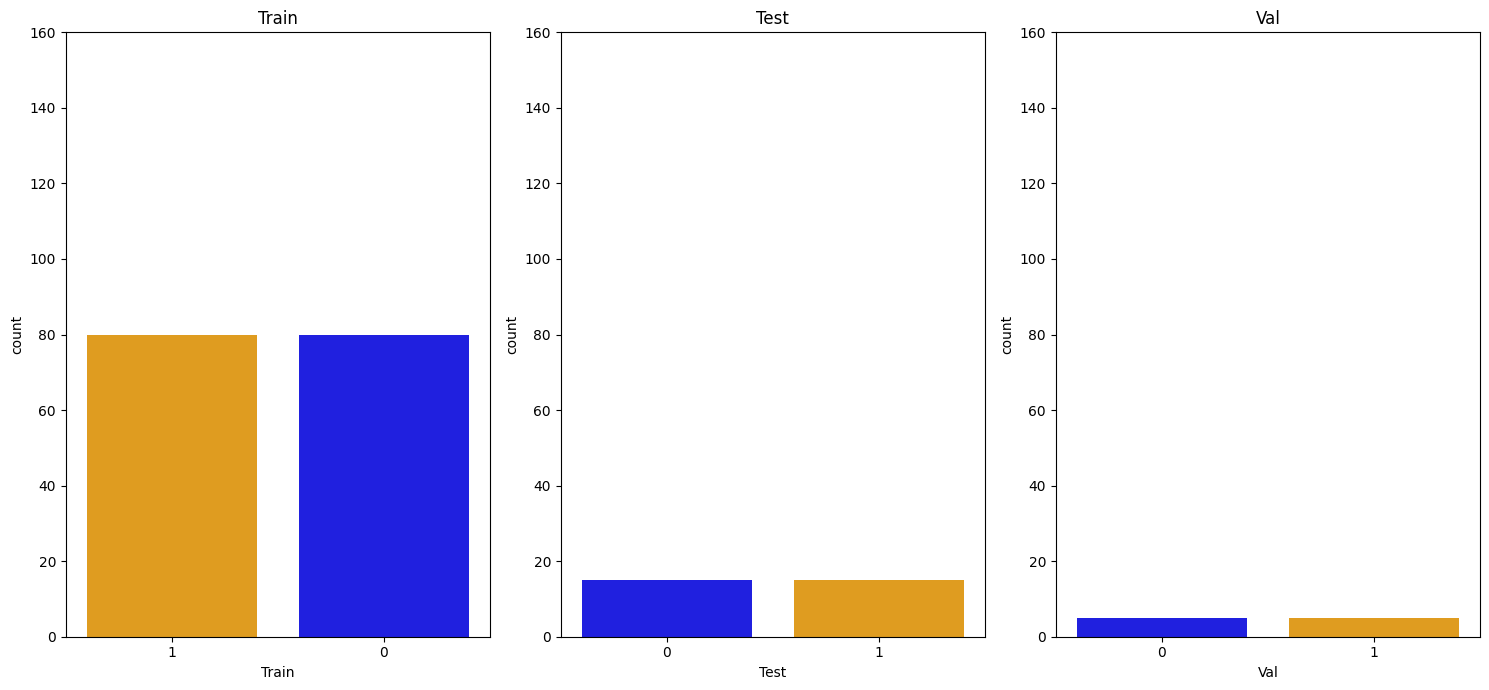

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Criando DataFrames separados
df_train = pd.DataFrame({'Train': y})
df_test = pd.DataFrame({'Test': t})
df_val = pd.DataFrame({'Val': m})

# Convertendo valores inteiros para strings para correspondência correta
df_train['Train'] = df_train['Train'].astype(str)
df_test['Test'] = df_test['Test'].astype(str)
df_val['Val'] = df_val['Val'].astype(str)

# Configurando a visualização
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

# Cores para os valores '0' e '1'
palette = {'0': 'blue', '1': 'orange'}

# Plotando os dados de treino com cores específicas
sns.countplot(x='Train', hue='Train', data=df_train, ax=ax[0], palette=palette, legend=False)
ax[0].set_title('Train')
ax[0].set_ylim(0, len(df_train))  # Ajuste conforme necessário para melhor visualização

# Plotando os dados de teste com cores específicas
sns.countplot(x='Test', hue='Test', data=df_test, ax=ax[1], palette=palette, legend=False)
ax[1].set_title('Test')
ax[1].set_ylim(0, len(df_train))  # Ajuste conforme necessário para melhor visualização

# Plotando os dados de validação com cores específicas
sns.countplot(x='Val', hue='Val', data=df_val, ax=ax[2], palette=palette, legend=False)
ax[2].set_title('Val')
ax[2].set_ylim(0, len(df_train))  # Ajuste conforme necessário para melhor visualização

plt.tight_layout()
plt.show()

### Lidar com o cálculo de pesos das classes

In [73]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y = np.array(y)  # Garantindo que 'y' é um array numpy, ajuste conforme necessário

# Verificando a versão do sklearn e ajustando a função compute_class_weight
try:
    # Tentativa de usar a função compute_class_weight se disponível
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
    class_weights = dict(enumerate(class_weights))
except AttributeError:
    # Se compute_class_weight foi descontinuada, usando uma alternativa
    from sklearn.utils import compute_sample_weight
    class_weights = compute_sample_weight(class_weight='balanced', y=y)
    unique_classes = np.unique(y)
    class_weights = {cls: np.mean(class_weights[y == cls]) for cls in unique_classes}

print(class_weights)

{0: 1.0, 1: 1.0}


#Distribuição dos dados de treino, validação e testes

In [74]:
import seaborn as sns
import gc

train_imgs = train_pn+ train_normal
del train_imgs
gc.collect()

X_train = np.array(X)
y_train = np.array(y)
X_test = np.array(P)
y_test = np.array(t)
X_val = np.array(K)
y_val = np.array(m)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(160, 224, 224, 3)
(160,)
(30, 224, 224, 3)
(30,)
(10, 224, 224, 3)
(10,)


###Limpar a memória

In [75]:
#Limpar a memória
del X
del y
gc.collect()

0

In [87]:
#Pegar o tamanho dos dados de treino e validação
ntrain = len(X_train)
nval = len(X_val)
batch_size = 32

#Treino da rede neural

In [77]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(  rotation_range=7,
                                     width_shift_range=0.05,
                                     height_shift_range=0.05,
                                     shear_range=0.2,
                                     zoom_range=0.45,
                                     horizontal_flip=True)

val_datagen = ImageDataGenerator(zoom_range=0.45)

In [78]:
#Criar os geradores de imagens
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [79]:
#Definir o tamanho das imagens
img_size = 224

In [80]:
from keras import layers
from keras import models
from keras import optimizers
from keras.applications import *
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import img_to_array, load_img
from keras.models import Model
from keras import backend as K

base_model = MobileNet(weights=None, include_top=False,input_shape=(img_size, img_size, 3))

x = base_model.output

x = GlobalAveragePooling2D()(x)

predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compilar o modelo
model.compile(optimizer='adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])

In [81]:
#Nós podemos ver os detalhes da arquitetura MobileNet
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

In [82]:
# Calculando os valores corretos para steps_per_epoch e validation_steps
steps_per_epoch = max(1, ntrain // batch_size)
validation_steps = max(1, nval // batch_size)

# Usando Model.fit com um gerador
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=class_weights
)

Epoch 1/10
5/5 [==============================] - 25s 470ms/step - loss: 0.8238 - binary_accuracy: 0.5437 - mae: 0.4813 - val_loss: 0.6932 - val_binary_accuracy: 0.5000 - val_mae: 0.5000
Epoch 2/10
5/5 [==============================] - 2s 387ms/step - loss: 0.6592 - binary_accuracy: 0.6875 - mae: 0.4369 - val_loss: 0.6933 - val_binary_accuracy: 0.5000 - val_mae: 0.5000
Epoch 3/10
5/5 [==============================] - 2s 383ms/step - loss: 0.5955 - binary_accuracy: 0.6625 - mae: 0.3647 - val_loss: 0.6932 - val_binary_accuracy: 0.5000 - val_mae: 0.5000
Epoch 4/10
5/5 [==============================] - 2s 386ms/step - loss: 0.4703 - binary_accuracy: 0.7750 - mae: 0.2855 - val_loss: 0.6933 - val_binary_accuracy: 0.5000 - val_mae: 0.5000
Epoch 5/10
5/5 [==============================] - 2s 396ms/step - loss: 0.5307 - binary_accuracy: 0.7750 - mae: 0.2847 - val_loss: 0.6934 - val_binary_accuracy: 0.5000 - val_mae: 0.5000
Epoch 6/10
5/5 [==============================] - 3s 570ms/step - los

#Plotar gráfico de treinamento e validação

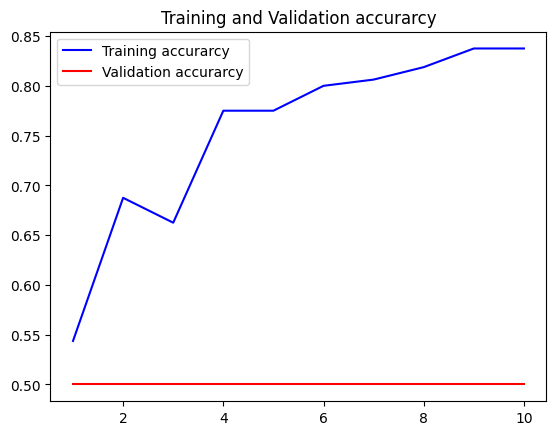

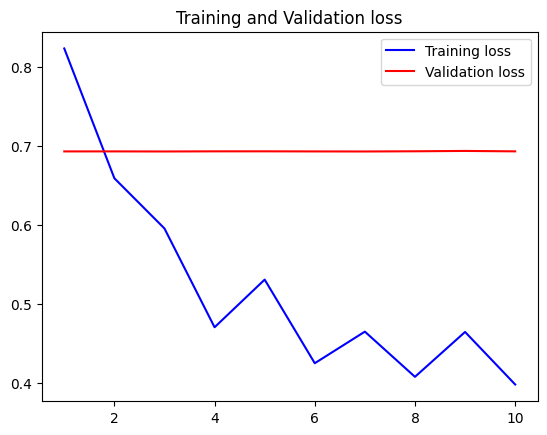

In [83]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Treino e validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()

#Treino e validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [84]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(X_test)

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))

tn, fp, fn, tp = cm.ravel()

print('MATRIZ DE CONFUSÃO ------------------')
print(cm)

print('\n============TEST METRICS=============')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Acurácia: {}%'.format(acc))
print('Precisão: {}%'.format(precision))
print('Revocação: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nMÉTRICA DE TREINO ----------------------')
print('Treino acc: {}'.format(np.round((history.history['binary_accuracy'][-1])*100, 2)))


1/1 [==============================] - 2s 2s/step
MATRIZ DE CONFUSÃO ------------------
[[ 0 15]
 [ 0 15]]

============TEST METRICS=============
Acurácia: 50.0%
Precisão: 50.0%
Revocação: 100.0%
F1-score: 66.66666666666667

MÉTRICA DE TREINO ----------------------
Treino acc: 83.75


#Matriz de confusão

<Axes: >

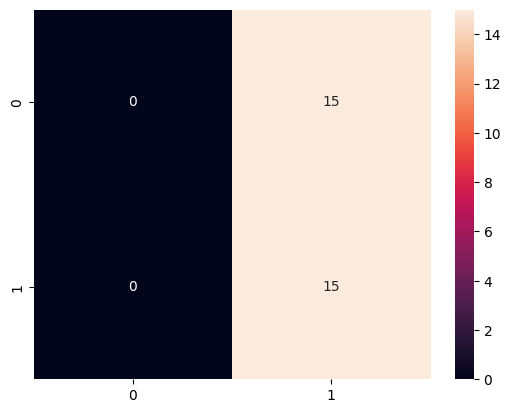

In [85]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d",)

#Curva ROC

AUC Score: 0.5


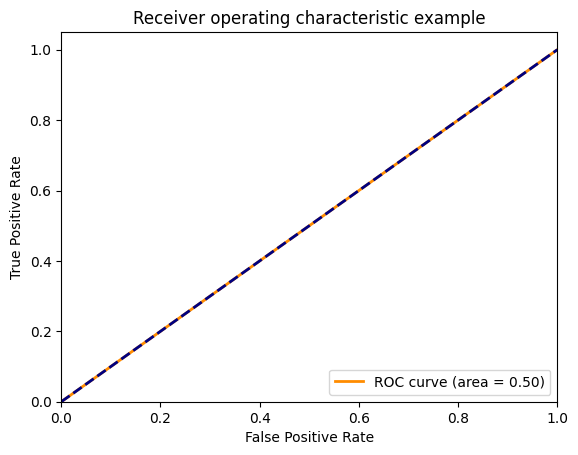

In [86]:
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

fpr , tpr , thresholds = roc_curve ( y_test , preds)
auc_keras = auc(fpr, tpr)
print("AUC Score:",auc_keras)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_keras)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()